# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Preprocessing

## Data Reading and Exploration

In [2]:
def read_data():
  X = pd.read_csv('../data/train.csv')
  y = pd.read_csv('../data/labels.csv')
  X_test = pd.read_csv('../data/test.csv')
  return X, y, X_test

def drop_first_column(X, y, X_test):
  X_id = X['Unnamed: 0']
  X = X.drop('Unnamed: 0', axis=1 )
  y = y.drop(columns=['Unnamed: 0'])
  X_test_id = X_test['Unnamed: 0']
  X_test = X_test.drop('Unnamed: 0', axis=1 )

  return X, X_id, y, X_test, X_test_id

def data_basic_info(X, y):
  X_shape = X.shape
  n_samples = X_shape[0]
  n_features = X_shape[1]
  n_diabetes = (y['Diabetes_binary'] == 1).sum()
  percentage_of_diabetes = n_diabetes / n_samples * 100

  print("Number of Samples : ", n_samples)
  print("Number of Features : ", n_features)
  print('Number of sample labelled as diabetes : ', n_diabetes)
  print('Percentage of diabetes : ', percentage_of_diabetes)
  print()

  X.info()

In [3]:
X, y, X_test = read_data()
X, X_id, y, X_test, X_test_id = drop_first_column(X, y, X_test)
data_basic_info(X, y)

#unique_values_X = {}
#for col in X.columns:
#  unique_values_X[col] = X[col].value_counts().shape[0]
#pd.DataFrame(unique_values_X, index=['unique value count X']).transpose()

#unique_values_X_test = {}
#for col in X_test.columns:
#  unique_values_X_test[col] = X_test[col].value_counts().shape[0]
#pd.DataFrame(unique_values_X_test, index=['unique value count X test']).transpose()

Number of Samples :  202944
Number of Features :  28
Number of sample labelled as diabetes :  28349
Percentage of diabetes :  13.968878114159573

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202944 entries, 0 to 202943
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HighBP                202944 non-null  int64  
 1   HighChol              202944 non-null  int64  
 2   CholCheck             202944 non-null  int64  
 3   BMI                   202944 non-null  float64
 4   Smoker                202944 non-null  int64  
 5   Stroke                202944 non-null  int64  
 6   HeartDiseaseorAttack  202944 non-null  int64  
 7   PhysActivity          202944 non-null  int64  
 8   Fruits                202944 non-null  int64  
 9   Veggies               202944 non-null  int64  
 10  HvyAlcoholConsump     202944 non-null  int64  
 11  AnyHealthcare         202944 non-null  int64  
 12  NoDocbcCos

## Data Encoding

In [4]:
bmi_category_order = ['Underweight', 'Normal weight', 'Overweight', 'Obese']
age_group_order = ['Young']
education_level_order = ['No High School', 'High School Graduate', 'Some College']
income_group_order = ['Low Income', 'Middle Income', 'High Income']

def ordinal_feature_encoding(X, X_test):
  non_numerical_col = X.select_dtypes(exclude=['number']).columns
  ordinal_encoder = OrdinalEncoder(categories=[bmi_category_order, age_group_order, education_level_order, income_group_order])
  
  X[non_numerical_col] = ordinal_encoder.fit_transform(X[non_numerical_col])
  X_test[non_numerical_col] = ordinal_encoder.transform(X_test[non_numerical_col])

  return X, X_test, non_numerical_col


In [5]:
X_encoded, X_test_encoded, non_numerical_col = ordinal_feature_encoding(X, X_test)
print(X_encoded.head())
print(X_test_encoded.head())


   HighBP  HighChol  CholCheck        BMI  Smoker  Stroke  \
0       0         1          1  20.693674       1       0   
1       0         0          1  28.375985       0       0   
2       1         1          1  24.629353       0       0   
3       0         1          1  27.246610       0       0   
4       0         1          1  23.671678       0       0   

   HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  ...        Age  \
0                     0             1       1        1  ...  11.725312   
1                     0             1       0        1  ...   7.977719   
2                     0             1       1        1  ...   8.161838   
3                     0             1       1        1  ...   5.038298   
4                     0             1       1        1  ...  12.037360   

   Education  Income  BMI_Category  Healthy_Diet  Mental_Health_Risk  \
0        6.0     8.0           1.0             1                   0   
1        5.0     8.0           3.0          

## Feature Selection

In [6]:
binary_features = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex', 'Healthy_Diet', 'Mental_Health_Risk']
continuous_features = ['BMI', 'MentHlth', 'PhysHlth', 'Age']
ordinal_features = ['GenHlth', 'Education', 'Income', 'BMI_Category', 'Heart_Disease_Risk', 'Age_Group', 'Education_Level', 'Income_Group']

In [7]:
def get_mutual_info(x_train, features, y_train, discrete=None):
    if discrete == None:
        mi_scores = mutual_info_classif(x_train[features], y_train['Diabetes_binary'])
    else:
        mi_scores = mutual_info_classif(x_train[features], y_train['Diabetes_binary'], discrete_features=discrete)
    
    return pd.DataFrame({'Features': features, 'Mutual Information Scores': mi_scores}).sort_values(by='Mutual Information Scores', ascending=False)


In [8]:
print(get_mutual_info(X_encoded, binary_features, y, True))
print(get_mutual_info(X_encoded, continuous_features, y))
print(get_mutual_info(X_encoded, ordinal_features, y, False))

                Features  Mutual Information Scores
0                 HighBP                   0.034746
12              DiffWalk                   0.020313
1               HighChol                   0.019329
5   HeartDiseaseorAttack                   0.012736
15    Mental_Health_Risk                   0.008292
6           PhysActivity                   0.006462
4                 Stroke                   0.004536
2              CholCheck                   0.002984
3                 Smoker                   0.001919
9      HvyAlcoholConsump                   0.001898
14          Healthy_Diet                   0.001592
8                Veggies                   0.001529
7                 Fruits                   0.000774
13                   Sex                   0.000507
11           NoDocbcCost                   0.000503
10         AnyHealthcare                   0.000132
   Features  Mutual Information Scores
0       BMI                   0.025120
3       Age                   0.019336

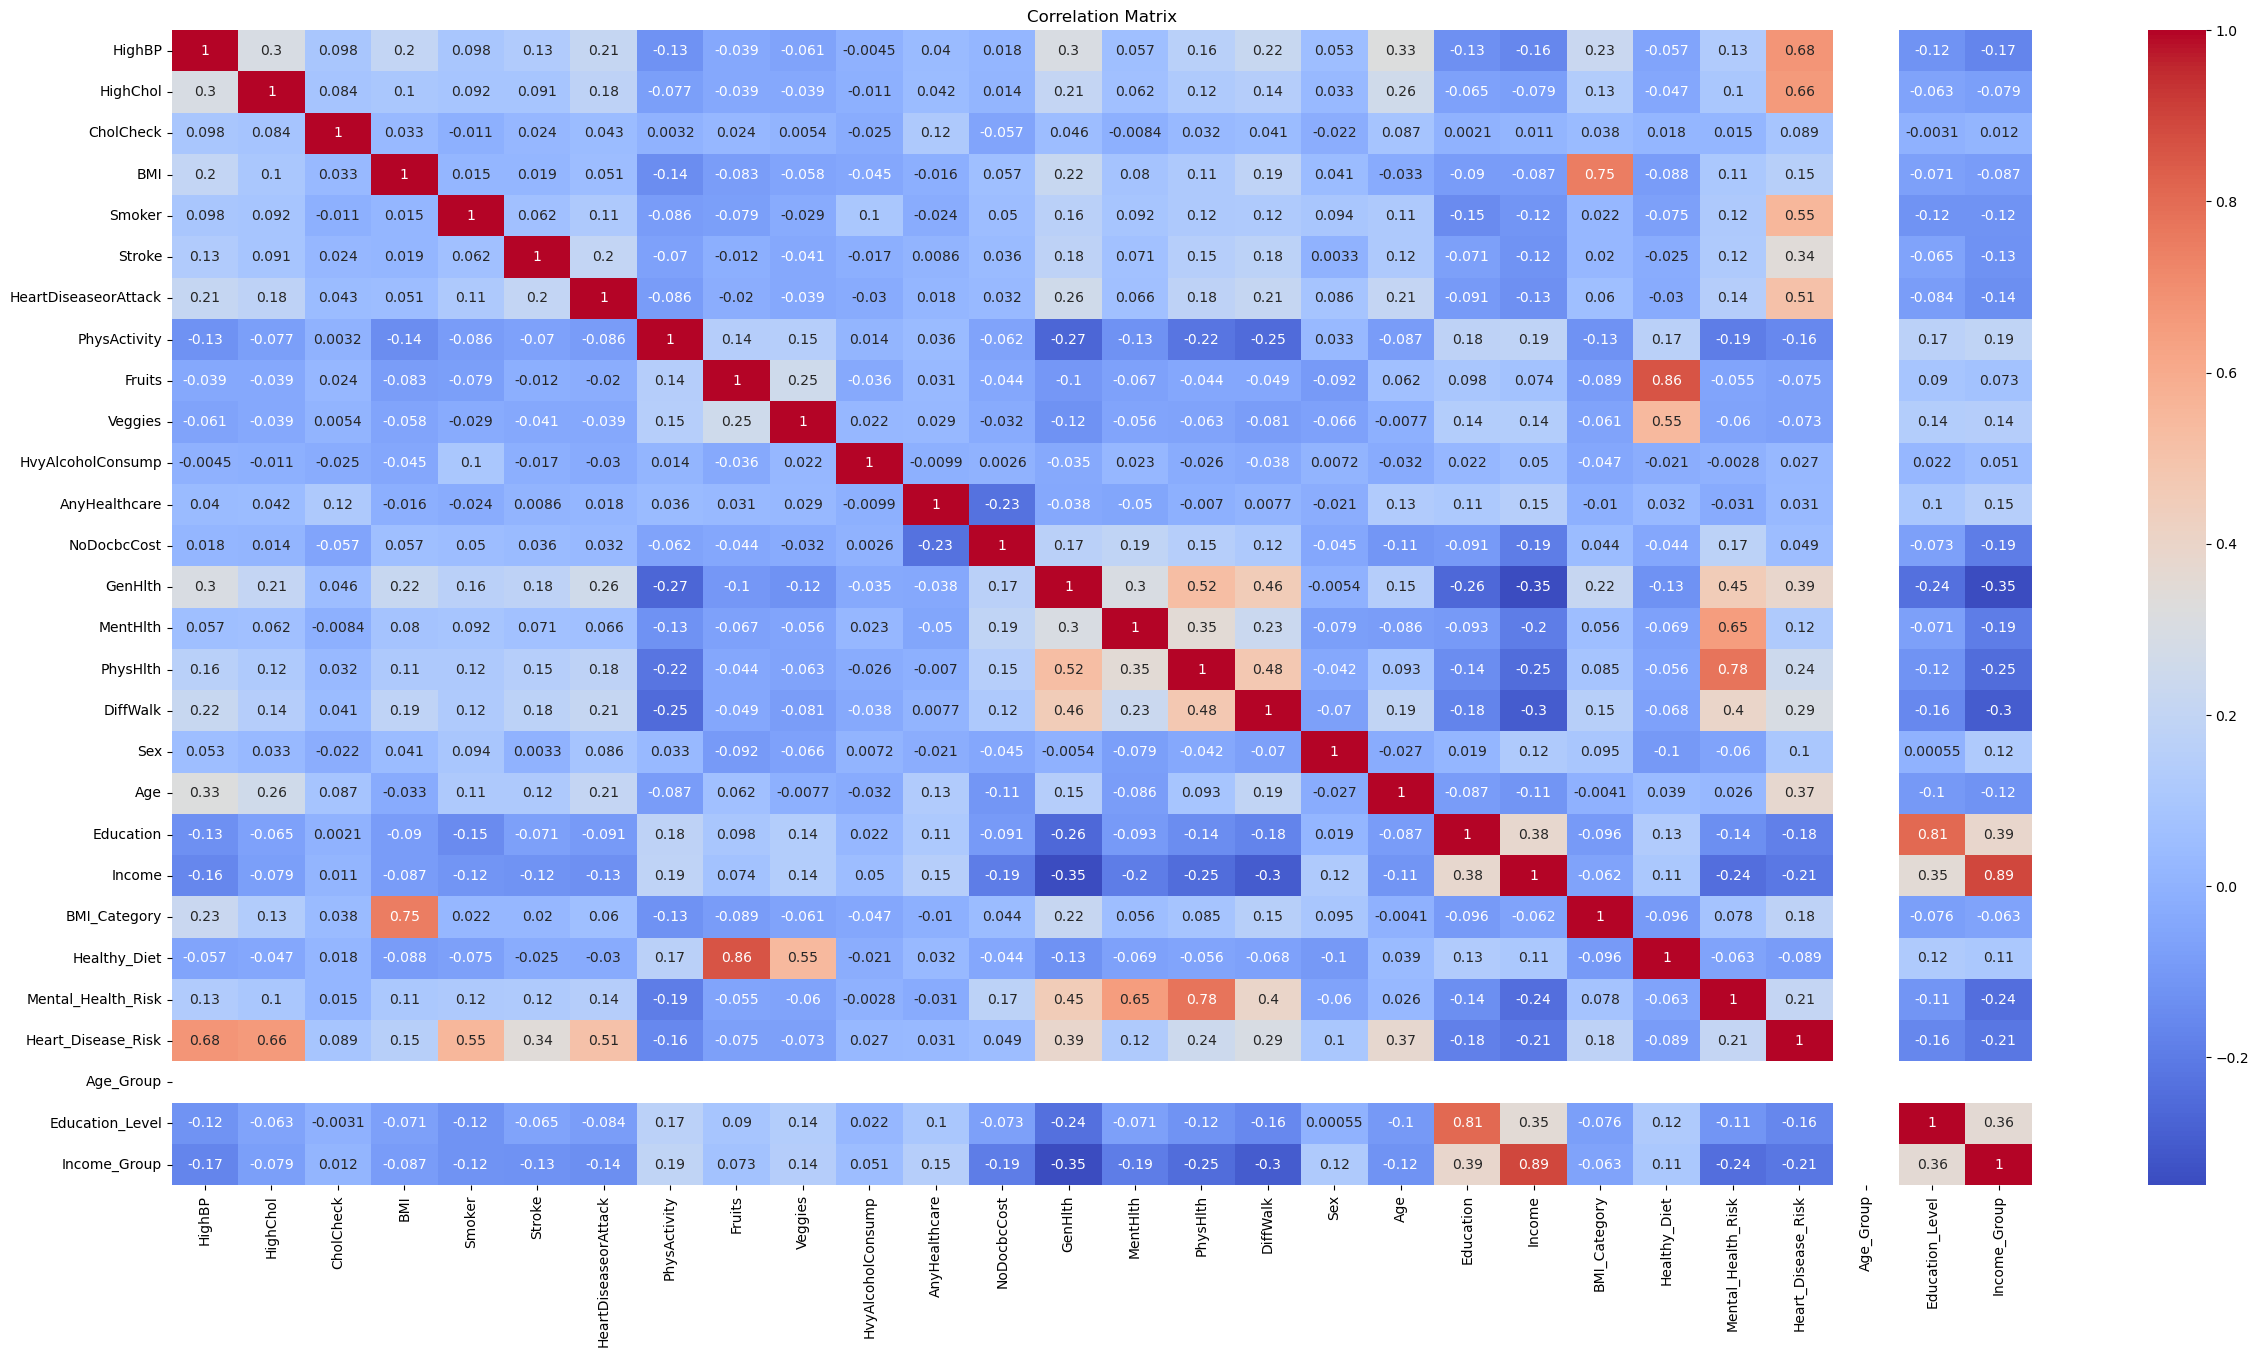

In [9]:
def plot_correlation_matrix(X):
  corr = X.select_dtypes(include=[float, int]).corr()
  plt.figure(figsize=(30, 15))
  sns.heatmap(corr, annot=True, cmap='coolwarm')
  plt.title('Correlation Matrix')
  plt.show()

plot_correlation_matrix(X_encoded)

In [7]:
features_to_drop = ['Age_Group', 'Fruits', 'Sex', 'NoDocbcCost', 'AnyHealthcare', 'BMI_Category', 'Education_Level', 'Income_Group', 'Mental_Health_Risk', 'Heart_Disease_Risk']

X_encoded = X_encoded.drop(columns=features_to_drop)
X_test_encoded = X_test_encoded.drop(columns=features_to_drop)


In [8]:
def data_splits(X, y):
    """
    Split the 'features' and 'labels' data into training and testing sets.
    Input(s): X: features (pd.DataFrame), y: labels (pd.DataFrame)
    Output(s): X_train, X_test, y_train, y_test
    """
    # Use random_state = 0 in the train_test_split
    # TODO write data split here
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    X_train = pd.DataFrame(X_train, columns=X.columns)
    X_test = pd.DataFrame(X_test, columns=X.columns)
    y_train = pd.DataFrame(y_train, columns=y.columns)
    y_test = pd.DataFrame(y_test, columns=y.columns)

    return X_train, X_test, y_train, y_test


def normalize_features(X_train, X_test):
    """
    Take the input data and normalize the features.
    Inp
    Output: X_train_scaled, X_test_scaled (pd.DataFrame) the same shape of X_train and X_test
    """
    # TODO write normalization here
    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(X_train)

    X_train_scaled = min_max_scaler.transform(X_train)
    X_test_scaled = min_max_scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    return X_train_scaled, X_test_scaled

In [9]:
X_train_split, X_test_split, y_train_split, y_test_split = data_splits(X_encoded, y)
X_train_split_scaled, X_test_split_scaled = normalize_features(X_train_split, X_test_split)

In [10]:
print(X_train_split_scaled.head())
print(X_test_split_scaled.head())

   HighBP  HighChol  CholCheck       BMI  Smoker  Stroke  \
0     0.0       0.0        1.0  0.152363     1.0     0.0   
1     1.0       1.0        1.0  0.199086     0.0     0.0   
2     1.0       0.0        1.0  0.192563     0.0     0.0   
3     0.0       0.0        0.0  0.192563     0.0     0.0   
4     1.0       0.0        1.0  0.225093     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Veggies  HvyAlcoholConsump  GenHlth  \
0                   0.0           1.0      0.0                0.0     0.50   
1                   1.0           1.0      1.0                0.0     0.50   
2                   0.0           1.0      1.0                0.0     0.25   
3                   0.0           0.0      1.0                0.0     0.50   
4                   0.0           1.0      1.0                0.0     0.25   

   MentHlth  PhysHlth  DiffWalk       Age  Education    Income  Healthy_Diet  
0  0.059398  0.076597       0.0  0.590620        0.8  1.000000           0.0  
1  0.058057 

# Training

In [ ]:
param_grid_decision_tree = {
    'max_depth': [5, 10, 15, 20, 25, 50, None], #5
    'min_samples_split': [2, 4, 6], #3
    'max_leaf_nodes': [400, 500, 600, 750] #4
}

In [11]:
def perform_grid_search(model, X_train_scaled, y_train, params, n_folds, n_jobs):
    print("Performing grid search for ", model)
    # Define the cross-validation strategy
    strat_kfold = StratifiedKFold(n_splits=n_folds) # TODO

    # Grid search for the model
    #"f1_macro": Calculates F1-score per class and takes the average, treating all classes equally.
    #"f1_weighted": Calculates F1-score per class and takes a weighted average, considering class imbalance.
    grid_search = GridSearchCV(model, params, scoring='f1', cv=strat_kfold, n_jobs=n_jobs) # n_jobs=10 uses 10 parallel processes. Speeds up the process

    if isinstance(model, RandomForestClassifier):
        grid_search.fit(X_train_scaled, y_train.values.ravel())
    else:
        grid_search.fit(X_train_scaled, y_train)
    best_param = grid_search.best_params_
    best_score = grid_search.best_score_
    print("Best parameters are:", best_param)
    print("Best score is:", best_score)

    return best_param, best_score

In [12]:
def compute_prediction(model, X_training_set, y_training_set, X_testing_set, y_testing_set):
    model.fit(X_training_set, y_training_set)
    y_testing_set_pred = model.predict(X_testing_set)
    pred_accuracy = accuracy_score(y_testing_set, y_testing_set_pred)
    pred_f1_score = f1_score(y_testing_set, y_testing_set_pred)

    return y_testing_set_pred, pred_accuracy, pred_f1_score

In [92]:
def multiple_split_training(n_training, x_training_set, y_training_set, model, params):
    results = []
    for i in range(0, n_training):
        x_train_split, y_train_split, x_test_split, y_test_split = data_splits(x_training_set, y_training_set)    
        results.append(perform_grid_search(model, x_train_split, y_train_split, params, -1))
    
    return results
        

## Models

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

cls_decision_tree = DecisionTreeClassifier(class_weight={0: 1, 1: 3}, random_state=0)

# No need to tune min_samples_split, min_samples_leaf, class_weight, criterion
#param_grid_decision_tree = {
#    'max_depth': [x for x in range(150, 241, 10)],
#}

perform_grid_search(cls_decision_tree, X_train_split_scaled, y_train_split, param_grid_decision_tree, 10, -1)

Performing grid search for  DecisionTreeClassifier(class_weight={0: 1, 1: 3}, random_state=0)
Best parameters are: {'max_depth': 10, 'max_features': None, 'max_leaf_nodes': 400, 'min_samples_split': 2}
Best score is: 0.4481405505900466


({'max_depth': 10,
  'max_features': None,
  'max_leaf_nodes': 400,
  'min_samples_split': 2},
 0.4481405505900466)

In [126]:
tuned_decision_tree = DecisionTreeClassifier(class_weight={0: 1, 1: 3}, random_state=0, max_depth=10, max_leaf_nodes=400, min_samples_split=2)
dt_pred, dt_accuracy, dt_f1 = compute_prediction(tuned_decision_tree, X_train_split_scaled, y_train_split, X_test_split_scaled, y_test_split)
print("Accuracy : ", dt_accuracy)
print("F1 Score : ", dt_f1)

Accuracy :  0.8064992978393161
F1 Score :  0.4459650112866817


In [125]:
#params_test_multi = {
#    'criterion': ['gini', 'entropy'],
#    'max_depth': [10, 20]
#}

#print(multiple_split_training(3, X_encoded, y, DecisionTreeClassifier(class_weight={0: 1, 1: 4}), params_test_multi))

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid_random_forest = {
    'n_estimators': [1000, 1250, 1500],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 4, 10],
}

cls_random_forest = RandomForestClassifier(class_weight='balanced', random_state=0)

perform_grid_search(cls_random_forest, X_train_split_scaled, y_train_split, param_grid_random_forest, 5, -1)


Performing grid search for  RandomForestClassifier(class_weight='balanced', random_state=0)


KeyboardInterrupt: 

In [18]:
tuned_random_forest = RandomForestClassifier(class_weight={0: 1, 1: 3}, random_state=0, max_depth=10, min_samples_split=10, n_estimators=1500)
rf_pred, rf_accuracy, rf_f1 = compute_prediction(tuned_random_forest, X_train_split_scaled, y_train_split, X_test_split_scaled, y_test_split)
print("Accuracy : ", rf_accuracy)
print("F1 Score : ", rf_f1)

c:\Miniconda3\envs\INF8245AE-Kaggle\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy :  0.8215033629801177
F1 Score :  0.4536611115300505


In [ ]:
#Accuracy :  0.8258641503855725
#F1 Score :  0.4626729511935533

#Accuracy :  0.823720712508315
#F1 Score :  0.4536916851187295

#Accuracy :  0.8251989455271133
#F1 Score :  0.4571122503634555

### Stacking

In [ ]:
base_models = [('rf', RandomForestClassifier(class_weight='balanced')),
               ('svm', SVC(probability=True))]

meta_model = LogisticRegression(class_weight='balanced')

stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

params_grid_search = {
    'rf__n_estimators': [100],
    'rf__max_depth': [10],
    'svm__C': [1],
    'svm__kernel': ['rbf'],
    'final_estimator__C': [1]
}

perform_grid_search(stacking_model, X_train_split_scaled, y_train_split, params_grid_search, n_jobs=4)

In [ ]:
base_models = [('rf', RandomForestClassifier(class_weight='balanced', random_state=0, max_depth=10, min_samples_split=10, n_estimators=1500)),
               ('svm', SVC(probability=True, kernel='linear'))]

meta_model = LogisticRegression(class_weight={0: 1, 1: 4})

stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

stacking_pred, stacking_accuracy, stacking_f1 = compute_prediction(stacking_model, X_train_split_scaled, y_train_split, X_test_split_scaled, y_test_split)

c:\Miniconda3\envs\INF8245AE-Kaggle\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Miniconda3\envs\INF8245AE-Kaggle\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


# Kaggle Submission

In [40]:
def kaggle_submission(model, X_testing_scaled, x_testing_id):
    y_pred_sub = model.predict(X_testing_scaled)
    n_samples_test = len(y_pred_sub)
    print("n samples : ", n_samples_test)
    n_diabetes_test = (y_pred_sub == 1).sum()
    print("n diabetes : ", n_diabetes_test)
    percentage_of_diabetes_test = n_diabetes_test / n_samples_test * 100
    print("percentage : ", percentage_of_diabetes_test)
    y_pred_sub = pd.DataFrame({
        'index': x_testing_id , 
        'Diabetes_binary': y_pred_sub,
    })

    # Save the predictions to a CSV file
    y_pred_sub.to_csv(f'./sub_y_pred.csv', index=False)

def submission_pred(model, X_testing_scaled):
    return model.predict(X_testing_scaled)

def submission_proba(model, X_testing_scaled):
    return model.predict_proba(X_testing_scaled)[:, 1]

In [41]:
kaggle_submission(tuned_random_forest, X_test_encoded, X_test_id)

n samples :  50736
n diabetes :  24022
percentage :  47.347051403342796
